# Task
Train a YOLOv8l model.

## Install Ultralytics

### Subtask:
Install the Ultralytics library using pip. This will provide access to the YOLOv8 models and training utilities.


**Reasoning**:
To install the Ultralytics library, a pip install command needs to be executed.



In [ ]:
# !pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.5 MB/s eta 0:00:00


## Train YOLOv8l Model

### Subtask:
Write Python code to load the YOLOv8l model and begin training. This step will include specifying a dataset for training (e.g., COCO or a custom dataset) and configuring training parameters like epochs, batch size, and image size. I will provide example code that you can adapt to your specific dataset and requirements.


# Dataset Visualization

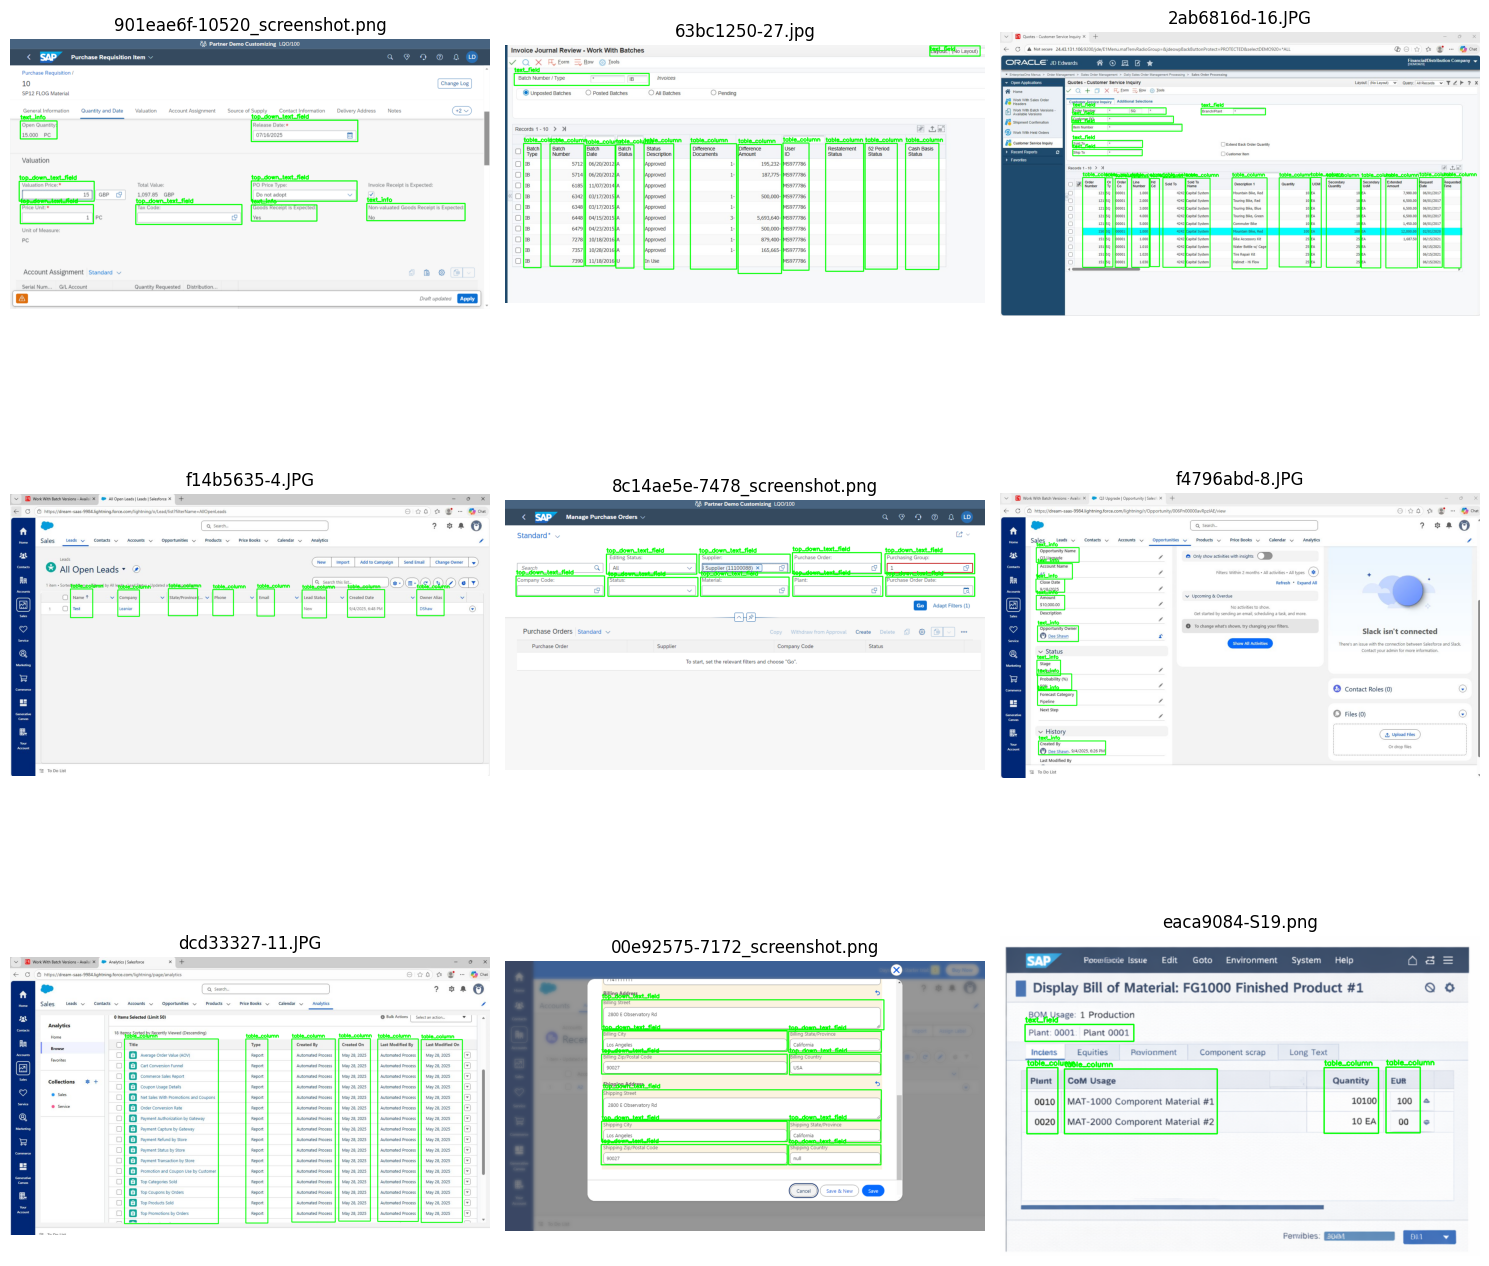

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ---------------- CONFIG ----------------
DATASET_DIR = "../label-studio-annotation-2026-02-09"
IMAGE_DIR = os.path.join(DATASET_DIR, "images")
LABEL_DIR = os.path.join(DATASET_DIR, "labels")
CLASSES_FILE = os.path.join(DATASET_DIR, "classes.txt")

NUM_IMAGES = 9
GRID_COLS = 3
SEED = 42
# ----------------------------------------

random.seed(SEED)

# Load class names (if available)
class_names = []
if os.path.exists(CLASSES_FILE):
    with open(CLASSES_FILE, "r") as f:
        class_names = [c.strip() for c in f.readlines()]

# Get images
images = [
    f for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

random.shuffle(images)
images = images[:NUM_IMAGES]


def draw_polygons(image, label_path, class_names):
    h, w, _ = image.shape

    if not os.path.exists(label_path):
        return image

    with open(label_path, "r") as f:
        for line in f:
            values = list(map(float, line.strip().split()))

            # Case B: class + polygon
            if len(values) == 9:
                cls = int(values[0])
                coords = values[1:]
                label = class_names[cls] if cls < len(class_names) else str(cls)

            # Case A: polygon only
            elif len(values) == 8:
                coords = values
                label = None

            else:
                print(f"⚠️ Skipping invalid label: {label_path}")
                continue

            # Convert normalized → pixel coords
            points = []
            for i in range(0, len(coords), 2):
                x = int(coords[i] * w)
                y = int(coords[i + 1] * h)
                points.append([x, y])

            pts = np.array(points, np.int32).reshape((-1, 1, 2))

            color = (0, 255, 0)
            cv2.polylines(image, [pts], isClosed=True, color=color, thickness=2)

            # Put label text
            if label:
                x_text, y_text = points[0]
                cv2.putText(
                    image,
                    label,
                    (x_text, max(y_text - 5, 15)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color,
                    2
                )

    return image


# Plot images
rows = (NUM_IMAGES + GRID_COLS - 1) // GRID_COLS
plt.figure(figsize=(15, 5 * rows))

for idx, img_name in enumerate(images):
    img_path = os.path.join(IMAGE_DIR, img_name)
    label_path = os.path.join(LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = draw_polygons(img, label_path, class_names)

    plt.subplot(rows, GRID_COLS, idx + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# import shutil
# import os

# src_folder = "/content/runs/detect/train3"
# dst_parent = "/content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-01-28"

# # Ensure destination parent exists
# os.makedirs(dst_parent, exist_ok=True)

# # shutil.move(src_folder, dst_parent)


# # import os

# # folder = "/content/drive/MyDrive/POC-table-masking/yolo_dataset_2026_01_21/images/val"

# # file_count = sum(
# #     1 for f in os.listdir(folder)
# #     if os.path.isfile(os.path.join(folder, f))
# # )

# # print("Files:", file_count)


## Split Dataset and Make YOLO format

In [3]:
import os
import random
import shutil

# ---------------- CONFIG ----------------
DATASET_DIR = "../label-studio-annotation-2026-02-09"
IMAGE_DIR = os.path.join(DATASET_DIR, "images")
LABEL_DIR = os.path.join(DATASET_DIR, "labels")
CLASSES_FILE = os.path.join(DATASET_DIR, "classes.txt")

OUTPUT_DIR = "yolo_dataset_2026-02-09"
TRAIN_RATIO = 0.8
SEED = 42
# ----------------------------------------

random.seed(SEED)

# Create output directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(OUTPUT_DIR, "images", split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "labels", split), exist_ok=True)

# Copy classes.txt
shutil.copy(CLASSES_FILE, os.path.join(OUTPUT_DIR, "classes.txt"))

# Get all images
images = [
    f for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

random.shuffle(images)

split_idx = int(len(images) * TRAIN_RATIO)
train_images = images[:split_idx]
val_images = images[split_idx:]


def copy_files(image_list, split):
    for img_name in image_list:
        img_src = os.path.join(IMAGE_DIR, img_name)
        lbl_src = os.path.join(LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")

        img_dst = os.path.join(OUTPUT_DIR, "images", split, img_name)
        lbl_dst = os.path.join(OUTPUT_DIR, "labels", split, os.path.basename(lbl_src))

        shutil.copy(img_src, img_dst)

        if os.path.exists(lbl_src):
            shutil.copy(lbl_src, lbl_dst)
        else:
            print(f"⚠️ Warning: label missing for {img_name}")


copy_files(train_images, "train")
copy_files(val_images, "val")

print("✅ YOLO dataset split completed!")
print(f"Train images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")


✅ YOLO dataset split completed!
Train images: 71
Validation images: 18


**Reasoning**:
The subtask requires writing Python code to load the YOLOv8l model and initiate training with specified parameters.



In [4]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8l model
model = YOLO('yolov8l.pt')

# Train the model with specified parameters
# Replace 'coco128.yaml' with the path to your dataset configuration file if using a custom dataset.
# Ensure your custom dataset YAML file specifies paths to train/val images/labels, number of classes, and class names.
results = model.train(data='/home/kawsar/Desktop/Image-Masking/POC-table-masking/config/coco8.yaml', epochs=100, imgsz=640, batch=8)

print("Model training initiated successfully.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/kawsar/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


 26%|██▌       | 21.8M/83.7M [00:25<01:12, 901kB/s] 


KeyboardInterrupt: 

In [ ]:
# remove folder command
# !rm -rf /content/drive/MyDrive/POC-table-masking/train-2026-02-09/train

In [ ]:
import shutil
import os

src_folder = "/content/runs/detect/train"
dst_parent = "/content/drive/MyDrive/POC-table-masking/train-2026-02-09"

# Ensure destination parent exists
os.makedirs(dst_parent, exist_ok=True)

shutil.move(src_folder, dst_parent)


# import os

# folder = "/content/drive/MyDrive/POC-table-masking/yolo_dataset_2026_01_21/images/val"

# file_count = sum(
#     1 for f in os.listdir(folder)
#     if os.path.isfile(os.path.join(folder, f))
# )

# print("Files:", file_count)


'/content/drive/MyDrive/POC-table-masking/train-2026-02-09/train'

In [ ]:
# remove folder
# !rm -rf /content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09

## inference all images

In [ ]:
import os
import cv2
from ultralytics import YOLO

# -----------------------------
# CONFIG
# -----------------------------
MODEL_PATH = "/content/drive/MyDrive/POC-table-masking/train-2026-02-09/train/weights/best.pt"
IMAGE_DIR = "/content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09/images"
OUTPUT_DIR = "/content/drive/MyDrive/POC-table-masking/train-2026-02-09/annotation-2026-01-28"
CONF_THRESHOLD = 0.50

CLASS_NAMES = {
    0: "table_column",
    1: "text_field",
    2: "text_info",
    3: "top_down_text_field"
}

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# LOAD MODEL
# -----------------------------
model = YOLO(MODEL_PATH)

# -----------------------------
# RUN INFERENCE
# -----------------------------
results = model(
    source=IMAGE_DIR,
    conf=CONF_THRESHOLD,
    save=False,
    stream=True  # memory efficient
)

# -----------------------------
# DRAW & SAVE
# -----------------------------
for result in results:
    img = result.orig_img
    h, w, _ = img.shape

    if result.boxes is not None:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])

            label = f"{CLASS_NAMES[cls_id]} {conf:.2f}"

            # Draw box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Draw label
            cv2.putText(
                img,
                label,
                (x1, max(y1 - 10, 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2
            )

    # Save output
    output_path = os.path.join(OUTPUT_DIR, os.path.basename(result.path))
    cv2.imwrite(output_path, img)

print("Inference completed. Annotated images saved to:", OUTPUT_DIR)



image 1/89 /content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09/images/00e92575-7172_screenshot.png: 384x640 10 top_down_text_fields, 51.8ms
image 2/89 /content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09/images/0153b80e-34.jpg: 320x640 6 table_columns, 1 text_field, 50.9ms
image 3/89 /content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09/images/07697205-4947_screenshot.png: 384x640 2 top_down_text_fields, 35.4ms
image 4/89 /content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09/images/0aae6bac-9329_screenshot.png: 384x640 11 text_infos, 33.8ms
image 5/89 /content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09/images/1130a820-29.jpg: 448x640 20 text_fields, 77.7ms
image 6/89 /content/drive/MyDrive/POC-table-masking/train-2026-02-09/label-studio-annotation-2026-02-09/images/18876ed1-9018_screensho

In [ ]:
!zip -r train.zip /content/runs

In [ ]:
from google.colab import files
files.download("/content/train.zip")


In [ ]:
# move runs folder to the drive
!cp -r /content/runs /content/drive/MyDrive/POC-table-masking/runs

# Model Inference

In [ ]:
# load train yolo model and predict on image
from ultralytics import YOLO
import cv2
import numpy as np
import os

model_path = "/content/drive/MyDrive/POC-table-masking/runs/detect/train/weights/best.pt"

In [ ]:
model = YOLO(model_path)

In [ ]:
result1 = model.predict("/content/drive/MyDrive/POC-table-masking/images/1.PNG")

In [ ]:
import matplotlib.pyplot as plt

# Get the annotated image from the prediction results
annotated_image = result1[0].plot()

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

In [ ]:
extracted_data = []
CLASS_NAMES = {
    0: "table_column",
    1: "text_field",
    2: "text_info"
}

if result1[0].boxes is not None:
    for box in result1[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        cls_id = int(box.cls[0])
        label = CLASS_NAMES.get(cls_id, f"unknown_class_{cls_id}")
        extracted_data.append({
            "box": [x1, y1, x2, y2],
            "label": label
        })

print("Extracted Bounding Boxes and Labels:")
for item in extracted_data:
    print(item)

In [ ]:
pip install easyocr

In [ ]:
# Assign unique IDs to each extracted item and add placeholder for texts and header
processed_data = []
for i, item in enumerate(extracted_data):
    processed_item = {
        "uid": i + 1,  # Assigning a unique ID starting from 1
        "box": item["box"],
        "texts": [],  # Placeholder for extracted text
        "header": "",  # Placeholder for header information
        "type": item["label"] # Using the detected label as type
    }
    processed_data.append(processed_item)

print("Processed Data with Unique IDs:")
for item in processed_data:
    print(item)

In [ ]:
from torch._C import float32
import easyocr
import cv2

# Initialize EasyOCR reader
# You can specify languages, e.g., ['en'] for English
reader = easyocr.Reader(['en'])

def data_extraction_from_image(img_path: str):
  # Load the original image once
  # Assuming the image path is the one used for prediction
  original_image = cv2.imread(img_path)

  if original_image is None:
      print(f"Error: Could not load image from {img_path}")
  else:
      # Iterate through processed_data and apply EasyOCR
      for item in processed_data:
          x1, y1, x2, y2 = map(float32, item["box"])

          # Crop the image using bounding box coordinates
          cropped_image = original_image[y1:y2, x1:x2]

          # Check if the cropped image is valid
          if cropped_image.shape[0] > 0 and cropped_image.shape[1] > 0:
              # Apply EasyOCR to the cropped image
              ocr_results = reader.readtext(cropped_image)

              # Extract only the text from OCR results
              extracted_texts = []
              for (bbox, text, prob) in ocr_results:
                  # EasyOCR bounding box format is [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                  extracted_texts.append({"box": bbox, "text": text, "prob": prob})

              extracted_texts.sort(key=lambda x: (x['box'][0][1], x['box'][0][0]))
              # # Apply sorting based on the item type
              # if item["type"] in ["text_info", "table_column"]:
              #     # Sort by y-coordinate (top-most first), then by x-coordinate (left-most first)
              #     extracted_texts.sort(key=lambda x: (x['box'][0][1], x['box'][0][0]))
              # else:
              #     # Sort by x-coordinate (left-most first), then by y-coordinate (top-most first)
              #     extracted_texts.sort(key=lambda x: (x['box'][0][0], x['box'][0][1]))

              # Update the 'texts' field in processed_data
              item["texts"] = extracted_texts
          else:
              print(f"Warning: Cropped image for UID {item['uid']} is empty. Skipping OCR.")
              item["texts"] = [] # Ensure it's an empty list if cropping failed

      # print("Processed Data with Extracted Texts:")
      # for item in processed_data:
      #     print(item)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def annotate_all_extracted_texts(image_path: str, all_processed_data: list, draw_bbox: bool = True, fill_bbox_white: bool = False):
    # Load the original image
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Define visual properties
    box_color = (0, 255, 0)  # Green in BGR
    text_color = (0, 0, 255) # Red in BGR
    white_color = (255, 255, 255) # White in BGR for filling
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1

    for processed_data_item in all_processed_data:
        parent_x1, parent_y1, _, _ = processed_data_item["box"]
        texts_to_annotate = processed_data_item["texts"]

        for text_info in texts_to_annotate:
            if "text" in text_info and "box" in text_info:
                text_content = text_info["text"]
                # Create masked text with asterisks
                masked_text = "*" * (len(text_content) // 2) + "*" * (len(text_content) % 2)

                # EasyOCR bbox format: [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                # Extract the corners of the EasyOCR bounding box (relative to parent box)
                points = text_info["box"]
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]

                # Calculate absolute coordinates by adding parent box offset
                x1_abs = int(parent_x1 + min(x_coords))
                y1_abs = int(parent_y1 + min(y_coords))
                x2_abs = int(parent_x1 + max(x_coords))
                y2_abs = int(parent_y1 + max(y_coords))

                # Ensure valid bounding box (min_x < max_x, min_y < max_y) before proceeding
                if x2_abs <= x1_abs or y2_abs <= y1_abs:
                    print(f"Warning: Invalid bounding box for text '{text_content}'. Skipping.")
                    continue

                # Fill the bounding box with white if the flag is true
                if fill_bbox_white:
                    cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), white_color, cv2.FILLED)

                # Draw the bounding box outline if the flag is true
                if draw_bbox:
                    cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), box_color, thickness)

                # Get text size to center it
                (text_width, text_height), baseline = cv2.getTextSize(masked_text, font, font_scale, thickness)

                bbox_width = x2_abs - x1_abs
                bbox_height = y2_abs - y1_abs

                # Calculate centered horizontal position
                ideal_text_x = x1_abs + (bbox_width - text_width) // 2

                # Clamp text_x to ensure it stays within the horizontal bounds of the bbox
                text_x = max(x1_abs, min(ideal_text_x, x2_abs - text_width))

                # Calculate centered vertical position (baseline)
                # The overall vertical extent of the text (from top of ascenders to bottom of descenders) is text_height + baseline.
                # We want the center of this overall text extent to align with the center of the bounding box.
                bbox_center_y = y1_abs + bbox_height // 2

                # Calculate the ideal baseline y-coordinate such that the *vertical center* of the entire text string
                # (including ascenders and descenders) aligns with the center of the bounding box.
                ideal_text_y_baseline = bbox_center_y + (text_height - baseline) // 2

                # Clamp text_y to ensure it stays within vertical bounds
                # The text's top edge is at (text_y - text_height). Must be >= y1_abs. So text_y >= y1_abs + text_height.
                # The text's bottom edge is at (text_y + baseline). Must be <= y2_abs. So text_y <= y2_abs - baseline.
                text_y = max(y1_abs + text_height, min(ideal_text_y_baseline, y2_abs - baseline))

                # Put the masked text on the image
                cv2.putText(img, masked_text, (text_x, text_y), font, font_scale, text_color, thickness, cv2.LINE_AA)

    # Convert BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Image with All Extracted Texts Annotated and Masked')
    plt.show()

In [ ]:
# Call the new function to annotate all extracted texts on the image
# Example: Draw bounding boxes and fill them with white
annotate_all_extracted_texts(img_path, processed_data, draw_bbox=True, fill_bbox_white=True)

### Output Processed Data in JSON Format

This step converts the `processed_data` list of dictionaries into a human-readable JSON string. This is useful for exporting the extracted information for further processing or storage in a structured format.

### Populate Header with First Extracted Text

This step iterates through the `processed_data`. For each item, it checks if there are any extracted texts. If the `texts` list is not empty, the `text` value of the very first element in that list is assigned to the `header` field of the current item. This effectively sets the 'header' to the top-most, left-most text detected within each bounding box.

In [ ]:
for item in processed_data:
    if item["texts"]:
        # Assuming the first text in the sorted list is the header
        item["header"] = item["texts"][0]["text"]
    print(item["header"])

print("Processed Data with Header Populated:")
for item in processed_data:
    print(item)

In [ ]:
import json
import numpy as np

# Custom encoder to handle numpy types
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

# Convert the processed_data list to JSON format
# Using the custom encoder to handle numpy types present in the bounding box data
json_output = json.dumps(processed_data, indent=4, cls=NpEncoder)

print(json_output)

In [ ]:
# write json file
with open('output_pic1.json', 'w') as json_file:
    json.dump(json_output, json_file, indent=4)

# Final Task Plan

## Final Task
Since yolo model train done, let's finish the following task
1. Detect all text and it's corresponding bounding box.
2. Now assign an unique ID to every bounding box and text pair
3. Take user input


data class:
- uid: int
- box: list[float]
- texts: list[str]
- header: str
- type: str


## Summary:

### Q&A
The installation and training process involved successfully installing the Ultralytics library, loading a pre-trained YOLOv8l model, and initiating its training on the `coco128` dataset. The process included automatic downloads of both the model weights and the dataset when not found locally.

### Data Analysis Key Findings
*   The Ultralytics library, including `ultralytics-8.4.5`, was successfully installed via pip, along with necessary dependencies.
*   A pre-trained YOLOv8l model (`yolov8l.pt`) was loaded; its weights were automatically downloaded from Ultralytics assets.
*   The `coco128.yaml` dataset was selected for training, and the dataset images were automatically downloaded and unzipped to `/content/datasets` by the system.
*   The training process was successfully initiated using the loaded YOLOv8l model and `coco128` dataset, configured for 100 epochs, an image size of 640, and a batch size of 16.

### Insights or Next Steps
*   The Ultralytics library streamlines the setup process by automatically handling model weight and dataset downloads, making it efficient to start training.
*   The next crucial step is to evaluate the trained YOLOv8l model's performance on a validation set and provide instructions on how to use it for making predictions on new data.


# **Full pipeline**

## Ui element detection by yolo

In [ ]:
from ultralytics import YOLO

class UIElementDetector:
  def __init__(self, model_path: str = "assets/best.pt"):
    self.model = YOLO(model_path)

  def predict(self, image_path: str):
    if self.model is None:
      raise RuntimeError("Model not loaded. Call load() first.")
    result = self.model.predict(image_path)

    extracted_data = []
    CLASS_NAMES = {
        0: "table_column",
        1: "text_field",
        2: "text_info"
    }

    if result[0].boxes is not None:
        for box in result[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            cls_id = int(box.cls[0])
            label = CLASS_NAMES.get(cls_id, f"unknown_class_{cls_id}")
            extracted_data.append({
                "box": [x1, y1, x2, y2],
                "label": label
            })
    return extracted_data


In [ ]:
!pip install easyocr

## Data Extraction

In [ ]:
# load train yolo model and predict on image
import os
import cv2
import easyocr
import numpy as np

class DataExtractor:
  def __init__(self, model_path: str):
    self.reader = easyocr.Reader(['en'])
    self.ui_element_extractor = UIElementDetector(model_path)

  def get_data_from_image(self, image_path: str):
    # Assign unique IDs to each extracted item and add placeholder for texts and header
    extracted_data = self.ui_element_extractor.predict(image_path)
    processed_data = []
    for i, item in enumerate(extracted_data):
        processed_item = {
            "uid": i + 1,  # Assigning a unique ID starting from 1
            "box": item["box"],
            "texts": [],  # Placeholder for extracted text
            "header": "",  # Placeholder for header information
            "type": item["label"] # Using the detected label as type
        }
        processed_data.append(processed_item)

    # print("Processed Data with Unique IDs:")
    # for item in processed_data:
    #     print(item)
    return processed_data

  def data_extraction_from_image(self, img_path: str):
    processed_data = self.get_data_from_image(img_path)
    # Load the original image once
    # Assuming the image path is the one used for prediction
    original_image = cv2.imread(img_path)

    if original_image is None:
        print(f"Error: Could not load image from {img_path}")
    else:
        # Iterate through processed_data and apply EasyOCR
        for item in processed_data:
            x1, y1, x2, y2 = map(int, item["box"])

            # Crop the image using bounding box coordinates
            cropped_image = original_image[y1:y2, x1:x2]

            # Check if the cropped image is valid
            if cropped_image.shape[0] > 0 and cropped_image.shape[1] > 0:
                # Apply EasyOCR to the cropped image
                ocr_results = self.reader.readtext(cropped_image)

                # Extract only the text from OCR results
                extracted_texts = []
                for (bbox, text, prob) in ocr_results:
                    # EasyOCR bounding box format is [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                    extracted_texts.append({"box": bbox, "text": text, "prob": prob})

                extracted_texts.sort(key=lambda x: (x['box'][0][1], x['box'][0][0]))
                # # Apply sorting based on the item type
                # if item["type"] in ["text_info", "table_column"]:
                #     # Sort by y-coordinate (top-most first), then by x-coordinate (left-most first)
                #     extracted_texts.sort(key=lambda x: (x['box'][0][1], x['box'][0][0]))
                # else:
                #     # Sort by x-coordinate (left-most first), then by y-coordinate (top-most first)
                #     extracted_texts.sort(key=lambda x: (x['box'][0][0], x['box'][0][1]))

                # Update the 'texts' field in processed_data
                item["texts"] = extracted_texts
            else:
                print(f"Warning: Cropped image for UID {item['uid']} is empty. Skipping OCR.")
                item["texts"] = [] # Ensure it's an empty list if cropping failed

        # make header
        for item in processed_data:
          if item["texts"]:
              # Assuming the first text in the sorted list is the header
              item["header"] = item["texts"][0]["text"]
          # print(item["header"])
    return processed_data


### Initialize Data extractor and Receive processed data

In [ ]:
model_path = "/content/drive/MyDrive/POC-table-masking/train-2026-01-21/train3/weights/best.pt"
data_extractor = DataExtractor(model_path)

In [ ]:
img_path = "/content/drive/MyDrive/POC-table-masking/images/16.JPG"
# img_path = "/content/drive/MyDrive/POC-table-masking/images/2.JPG"
processed_data = data_extractor.data_extraction_from_image(img_path)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def annotate_all_texts(image_path: str, all_processed_data: list, draw_bbox: bool = True, fill_bbox_white: bool = False):
    # Load the original image
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Define visual properties
    box_color = (0, 255, 0)  # Green in BGR
    text_color = (0, 0, 255) # Red in BGR
    white_color = (255, 255, 255) # White in BGR for filling
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1

    for processed_data_item in all_processed_data:
        parent_x1, parent_y1, _, _ = processed_data_item["box"]
        texts_to_annotate = processed_data_item["texts"]

        for text_info in texts_to_annotate:
            if "text" in text_info and "box" in text_info:
                text_content = text_info["text"]
                # Create masked text with asterisks
                masked_text = "*" * (len(text_content) // 2) + "*" * (len(text_content) % 2)

                # EasyOCR bbox format: [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                # Extract the corners of the EasyOCR bounding box (relative to parent box)
                points = text_info["box"]
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]

                # Calculate absolute coordinates by adding parent box offset
                x1_abs = int(parent_x1 + min(x_coords))
                y1_abs = int(parent_y1 + min(y_coords))
                x2_abs = int(parent_x1 + max(x_coords))
                y2_abs = int(parent_y1 + max(y_coords))

                # Ensure valid bounding box (min_x < max_x, min_y < max_y) before proceeding
                if x2_abs <= x1_abs or y2_abs <= y1_abs:
                    print(f"Warning: Invalid bounding box for text '{text_content}'. Skipping.")
                    continue

                # Fill the bounding box with white if the flag is true
                if fill_bbox_white:
                    cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), white_color, cv2.FILLED)

                # Draw the bounding box outline if the flag is true
                if draw_bbox:
                    cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), box_color, thickness)

                # Get text size to center it
                (text_width, text_height), baseline = cv2.getTextSize(masked_text, font, font_scale, thickness)

                bbox_width = x2_abs - x1_abs
                bbox_height = y2_abs - y1_abs

                # Calculate centered horizontal position
                ideal_text_x = x1_abs + (bbox_width - text_width) // 2

                # Clamp text_x to ensure it stays within the horizontal bounds of the bbox
                text_x = max(x1_abs, min(ideal_text_x, x2_abs - text_width))

                # Calculate centered vertical position (baseline)
                # The overall vertical extent of the text (from top of ascenders to bottom of descenders) is text_height + baseline.
                # We want the center of this overall text extent to align with the center of the bounding box.
                bbox_center_y = y1_abs + bbox_height // 2

                # Calculate the ideal baseline y-coordinate such that the *vertical center* of the entire text string
                # (including ascenders and descenders) aligns with the center of the bounding box.
                ideal_text_y_baseline = bbox_center_y + (text_height - baseline) // 2

                # Clamp text_y to ensure it stays within vertical bounds
                # The text's top edge is at (text_y - text_height). Must be >= y1_abs. So text_y >= y1_abs + text_height.
                # The text's bottom edge is at (text_y + baseline). Must be <= y2_abs. So text_y <= y2_abs - baseline.
                text_y = max(y1_abs + text_height, min(ideal_text_y_baseline, y2_abs - baseline))

                # Put the masked text on the image
                # cv2.putText(img, masked_text, (text_x, text_y), font, font_scale, text_color, thickness, cv2.LINE_AA)

    # Convert BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Image with All Extracted Texts Annotated and Masked')
    plt.show()

In [ ]:
annotate_all_texts(img_path, processed_data, draw_bbox=True, fill_bbox_white=False)

### Masking all detected texts
Given an image, all texts will be masking which our final goals

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def annotate_all_extracted_texts(image_path: str, all_processed_data: list, draw_bbox: bool = True, fill_bbox_white: bool = False):
    # Load the original image
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Define visual properties
    box_color = (0, 255, 0)  # Green in BGR
    text_color = (0, 0, 255) # Red in BGR
    white_color = (255, 255, 255) # White in BGR for filling
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1

    for processed_data_item in all_processed_data:
        parent_x1, parent_y1, _, _ = processed_data_item["box"]
        texts_to_annotate = processed_data_item["texts"]

        for text_info in texts_to_annotate:
            if "text" in text_info and "box" in text_info:
                text_content = text_info["text"]
                # Create masked text with asterisks
                masked_text = "*" * (len(text_content) // 2) + "*" * (len(text_content) % 2)

                # EasyOCR bbox format: [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                # Extract the corners of the EasyOCR bounding box (relative to parent box)
                points = text_info["box"]
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]

                # Calculate absolute coordinates by adding parent box offset
                x1_abs = int(parent_x1 + min(x_coords))
                y1_abs = int(parent_y1 + min(y_coords))
                x2_abs = int(parent_x1 + max(x_coords))
                y2_abs = int(parent_y1 + max(y_coords))

                # Ensure valid bounding box (min_x < max_x, min_y < max_y) before proceeding
                if x2_abs <= x1_abs or y2_abs <= y1_abs:
                    print(f"Warning: Invalid bounding box for text '{text_content}'. Skipping.")
                    continue

                # Fill the bounding box with white if the flag is true
                if fill_bbox_white:
                    cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), white_color, cv2.FILLED)

                # Draw the bounding box outline if the flag is true
                if draw_bbox:
                    cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), box_color, thickness)

                # Get text size to center it
                (text_width, text_height), baseline = cv2.getTextSize(masked_text, font, font_scale, thickness)

                bbox_width = x2_abs - x1_abs
                bbox_height = y2_abs - y1_abs

                # Calculate centered horizontal position
                ideal_text_x = x1_abs + (bbox_width - text_width) // 2

                # Clamp text_x to ensure it stays within the horizontal bounds of the bbox
                text_x = max(x1_abs, min(ideal_text_x, x2_abs - text_width))

                # Calculate centered vertical position (baseline)
                # The overall vertical extent of the text (from top of ascenders to bottom of descenders) is text_height + baseline.
                # We want the center of this overall text extent to align with the center of the bounding box.
                bbox_center_y = y1_abs + bbox_height // 2

                # Calculate the ideal baseline y-coordinate such that the *vertical center* of the entire text string
                # (including ascenders and descenders) aligns with the center of the bounding box.
                ideal_text_y_baseline = bbox_center_y + (text_height - baseline) // 2

                # Clamp text_y to ensure it stays within vertical bounds
                # The text's top edge is at (text_y - text_height). Must be >= y1_abs. So text_y >= y1_abs + text_height.
                # The text's bottom edge is at (text_y + baseline). Must be <= y2_abs. So text_y <= y2_abs - baseline.
                text_y = max(y1_abs + text_height, min(ideal_text_y_baseline, y2_abs - baseline))

                # Put the masked text on the image
                cv2.putText(img, masked_text, (text_x, text_y), font, font_scale, text_color, thickness, cv2.LINE_AA)

    # Convert BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Image with All Extracted Texts Annotated and Masked')
    plt.show()

In [ ]:
annotate_all_extracted_texts(img_path, processed_data, draw_bbox=True, fill_bbox_white=True)

### Masking all targeted texts

Given an image and list of (text, bbox), this script will mask all the text with corresponding bounding box

In [ ]:
# annotate selected texts
import cv2
import matplotlib.pyplot as plt
import numpy as np

def annotate_targeted_texts(image_path: str, texts: list, draw_bbox: bool = True, fill_bbox_white: bool = False):
    # Load the original image
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Define visual properties
    box_color = (0, 255, 0)  # Green in BGR
    text_color = (0, 0, 255) # Red in BGR
    white_color = (255, 255, 255) # White in BGR for filling
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1


    # draw all boxes given in this list
    for (text_content, points) in texts:
        # Create masked text with asterisks
        masked_text = "*" * (len(text_content) // 2) + "*" * (len(text_content) % 2)
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]

        # Calculate absolute coordinates by adding parent box offset
        x1_abs = int(min(x_coords))
        y1_abs = int(min(y_coords))
        x2_abs = int(max(x_coords))
        y2_abs = int(max(y_coords))

        # Ensure valid bounding box (min_x < max_x, min_y < max_y) before proceeding
        if x2_abs <= x1_abs or y2_abs <= y1_abs:
            print(f"Warning: Invalid bounding box for text '{text_content}'. Skipping.")
            continue

        # Fill the bounding box with white if the flag is true
        if fill_bbox_white:
            cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), white_color, cv2.FILLED)

        # Draw the bounding box outline if the flag is true
        if draw_bbox:
            cv2.rectangle(img, (x1_abs, y1_abs), (x2_abs, y2_abs), box_color, thickness)

        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(masked_text, font, font_scale, thickness)

        bbox_width = x2_abs - x1_abs
        bbox_height = y2_abs - y1_abs

        # Calculate centered horizontal position
        ideal_text_x = x1_abs + (bbox_width - text_width) // 2

        # Clamp text_x to ensure it stays within the horizontal bounds of the bbox
        text_x = max(x1_abs, min(ideal_text_x, x2_abs - text_width))

        # Calculate centered vertical position (baseline)
        # The overall vertical extent of the text (from top of ascenders to bottom of descenders) is text_height + baseline.
        # We want the center of this overall text extent to align with the center of the bounding box.
        bbox_center_y = y1_abs + bbox_height // 2

        # Calculate the ideal baseline y-coordinate such that the *vertical center* of the entire text string
        # (including ascenders and descenders) aligns with the center of the bounding box.
        ideal_text_y_baseline = bbox_center_y + (text_height - baseline) // 2

        # Clamp text_y to ensure it stays within vertical bounds
        # The text's top edge is at (text_y - text_height). Must be >= y1_abs. So text_y >= y1_abs + text_height.
        # The text's bottom edge is at (text_y + baseline). Must be <= y2_abs. So text_y <= y2_abs - baseline.
        text_y = max(y1_abs + text_height, min(ideal_text_y_baseline, y2_abs - baseline))

        # Put the masked text on the image
        cv2.putText(img, masked_text, (text_x, text_y), font, font_scale, text_color, thickness, cv2.LINE_AA)

    # Convert BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Image with All Extracted Texts Annotated and Masked')
    plt.show()

### all value masking with header

In [ ]:
# extract all boxes related to user target text

# given header name, mask all text of the given header
# column_name = "Account Owner Alias"
column_name = "Description"
texts = []

# first mask all text for the given header
for item in processed_data:
    if item["header"].strip() == column_name.strip():
        parent_x1, parent_y1, _, _ = item["box"]
        texts_to_annotate = item["texts"]

        for text_info in texts_to_annotate:
            if "text" in text_info and "box" in text_info:
                text_content = text_info["text"]
                # Create masked text with asterisks
                # masked_text = "*" * (len(text_content) // 2) + "*" * (len(text_content) % 2)

                # EasyOCR bbox format: [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                # Extract the corners of the EasyOCR bounding box (relative to parent box)
                points = text_info["box"]
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]

                # Calculate absolute coordinates by adding parent box offset
                x1_abs = int(parent_x1 + min(x_coords))
                y1_abs = int(parent_y1 + min(y_coords))
                x2_abs = int(parent_x1 + max(x_coords))
                y2_abs = int(parent_y1 + max(y_coords))
                texts.append((text_content, [[x1_abs, y1_abs], [x2_abs, y2_abs]]))


In [ ]:
texts

In [ ]:
annotate_targeted_texts(img_path, texts, True, True)

### All targeted texts masking

In [ ]:
# extract all boxes related to user target text

# text to be masked
targeted_text = "Touring Bike"
texts = []

# first mask all text for the given header
for item in processed_data:
        parent_x1, parent_y1, _, _ = item["box"]
        texts_to_annotate = item["texts"]

        for text_info in texts_to_annotate:
            if "text" in text_info and "box" in text_info:
                text_content = text_info["text"]
                # match with targeted text
                if text_content.strip() != targeted_text.strip():
                    continue

                # EasyOCR bbox format: [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                # Extract the corners of the EasyOCR bounding box (relative to parent box)
                points = text_info["box"]
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]

                # Calculate absolute coordinates by adding parent box offset
                x1_abs = int(parent_x1 + min(x_coords))
                y1_abs = int(parent_y1 + min(y_coords))
                x2_abs = int(parent_x1 + max(x_coords))
                y2_abs = int(parent_y1 + max(y_coords))
                texts.append((text_content, [[x1_abs, y1_abs], [x2_abs, y2_abs]]))


In [ ]:
texts

In [ ]:
annotate_targeted_texts(img_path, texts, True, True)

## Summary:

### Data Analysis Key Findings

*   The `mask_processed_data` function was successfully implemented, supporting two distinct masking strategies:
    *   Masking all text associated with a specified header (e.g., 'Account Name').
    *   Masking specific text occurrences (e.g., 'DShaw').
*   The masking mechanism involves adding a `masked: True` flag to the relevant `text_info` dictionaries within a deep copy of the processed data, preserving the original data.
*   The `annotate_all_extracted_texts` function was successfully updated to interpret this `masked` flag, displaying masked text as asterisks (`*`) and unmasked text as its original content.
*   Visual demonstrations confirmed that both header-based and specific text-based masking scenarios functioned as intended, with the annotated output correctly showing masked entries.

### Insights or Next Steps

*   The implemented masking functionality provides a robust method for redacting sensitive information based on its association with headers or specific content.
*   Future enhancements could include implementing additional masking types, such as masking based on regular expressions, specific data types (e.g., dates, numbers), or predefined sensitive keywords.


# **New Dataset Visualization**

In [ ]:
!pip install -q gdown

In [ ]:
!gdown 1RlanXoW4TXLFhfn3Z_Z3Dde6T74UbKfC

In [ ]:
!unzip '/content/new images.zip'

In [ ]:
import os

img_list = os.listdir("/content/new images")

In [ ]:
len(img_list)

In [ ]:
from PIL import Image

#show image
img = Image.open(f'new images/{img_list[0]}')

In [ ]:
# !mv 'new images' 'large_dataset'

In [ ]:
import shutil

shutil.move("/content/large_dataset", "/content/drive/MyDrive/POC-table-masking")
